In [16]:
import numpy as np 
import pandas as pd 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [17]:
src_path_train = "C:/Users/DELL/Downloads/archive/Google_Recaptcha_V2_Images_Dataset/images/"
batch_size = 64

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        #rotation_range=20,
        zoom_range=0.05,
        #width_shift_range=0.05,
        #height_shift_range=0.05,
        #shear_range=0.05,
        horizontal_flip=True,
        #fill_mode="nearest",
        validation_split=0.20)

# 훈련 데이터를 생성하는 코드
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

# 검증 데이터를 생성하는 코드
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

Found 9388 images belonging to 12 classes.
Found 2342 images belonging to 12 classes.


In [18]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications

In [56]:
ROWS = 150   # 이미지의 높이
COLS = 150   # 이미지의 너비
input_shape = (ROWS, COLS, 3)   # 입력 이미지의 형식 (150x150 크기의 3채널 이미지)

# 사전 학습된 InceptionV3 모델을 불러옴. 
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,input_shape=(ROWS, COLS,3))

# InceptionV3의 앞쪽 150개의 레이어는 학습되지 않도록 고정 (기존 사전 학습된 가중치를 그대로 사용)
for i in base_model.layers[0:150]:
    i.trainable = False
# 150번째 이후의 레이어는 학습 가능하도록 설정
for i in base_model.layers[150::]:
    i.trainable = True

# 새로 추가할 모델 정의    
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())         # GlobalAveragePooling2D는 Fully Connected Layer를 대체하는 풀링 방식으로 파라미터 수를 줄임
add_model.add(Dropout(0.5))                     # 과적합을 방지하기 위해 임의로 뉴런을 50% 비활성화
add_model.add(Dense(12, activation='softmax'))  # 마지막 출력층으로, 12개의 클래스에 대해 소프트맥스 활성화 함수를 사용한 Dense 층 추가 (다중 분류)
model = add_model

# 모델 컴파일
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

# 모델 구조 요약 출력력
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │        24,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,827,372 (83.26 MB)

 Trainable params: 17,391,564 (66.34 MB)

 Non-trainable params: 4,435,808 (16.92 MB)

In [57]:
print(len(base_model.layers))

311


In [58]:
from sklearn.utils import compute_class_weight

# 'train_generator.classes'를 통해 학습 데이터의 각 이미지가 속한 클래스 레이블을 가져옴
# train_generator는 Keras의 ImageDataGenerator를 통해 생성된 객체
train_classes = train_generator.classes

# 'compute_class_weight'는 각 클래스의 가중치를 자동으로 계산함
class_weights = compute_class_weight(     # 클래스 비율을 자동으로 맞춤
    class_weight = "balanced",            # 클래스 목록을 넘겨줌 (중복 제거)
    classes = np.unique(train_classes),   # 각 이미지의 실제 클래스 레이블
    y = train_classes
    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
# np.unique(train_classes)로 얻은 클래스와, 그에 해당하는 가중치를 zip으로 묶어 딕셔너리로 변환
# 이를 통해 각 클래스에 해당하는 가중치를 딕셔너리 형태로 저장

class_weights   # 최종적으로 클래스별 가중치가 담긴 딕셔너리 출력

{0: 1.2537393162393162,
 1: 1.8321623731459797,
 2: 0.8081955922865014,
 3: 0.27479217890176794,
 4: 7.823333333333333,
 5: 0.7886424731182796,
 6: 1.02668416447944,
 7: 12.035897435897436,
 8: 0.7297885572139303,
 9: 1.073159579332419,
 10: 4.629191321499014,
 11: 1.2359136387572407}

In [60]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.keras',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose =1)

# 모델 학습
history = model.fit(train_generator, validation_data=valid_generator, callbacks=callback,
                    #class_weight=class_weights, 
                    epochs=10)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.6499 - loss: 1.1452
Epoch 1: val_accuracy improved from -inf to 0.74039, saving model to bestModel.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.6504 - loss: 1.1433 - val_accuracy: 0.7404 - val_loss: 0.8994
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.8272 - loss: 0.5216
Epoch 2: val_accuracy improved from 0.74039 to 0.79590, saving model to bestModel.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8272 - loss: 0.5217 - val_accuracy: 0.7959 - val_loss: 0.7107
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.8669 - loss: 0.4003
Epoch 3: val_accuracy improved from 0.79590 to 0.81725, saving model to bestModel.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8668 - loss: 0.4005 - val_accuracy: 0.8173 - val_loss: 0.6893
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.8959 - loss: 0.3144
Epoch 4: val_accuracy did not imp

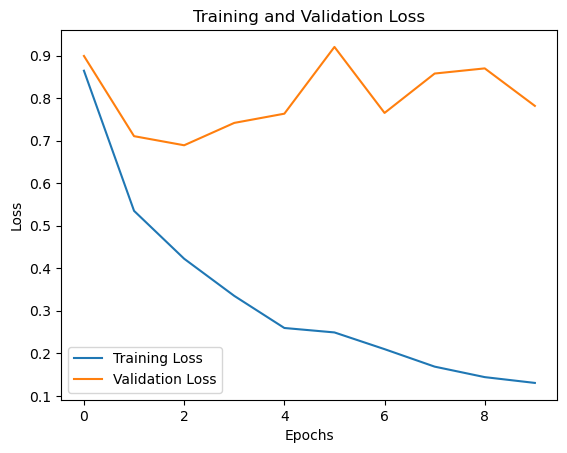

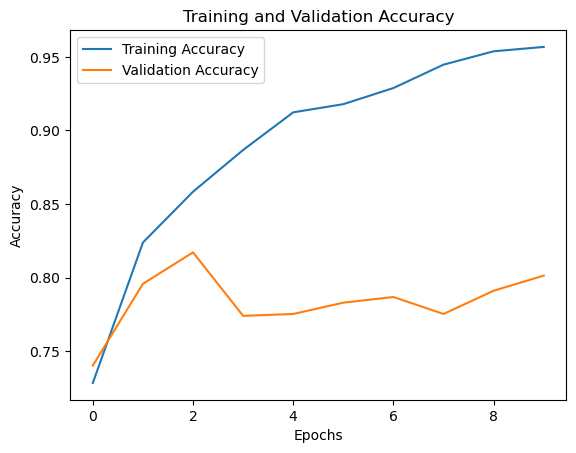

In [61]:
import matplotlib.pyplot as plt

# 훈련 손실 및 검증 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 정확도 및 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
model.evaluate(valid_generator)

37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 630ms/step - accuracy: 0.8077 - loss: 0.8219


[0.814393162727356, 0.8052946329116821]

In [31]:
from keras.models import load_model
best_model = load_model('bestModel.keras')
best_model.evaluate(valid_generator)

37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 608ms/step - accuracy: 0.8292 - loss: 1.0858


[1.1478532552719116, 0.8245089650154114]

In [63]:
best_model.save('GoogleRecaptcha_81.keras', include_optimizer=False)

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Bicycle',
 1: 'Bridge',
 2: 'Bus',
 3: 'Car',
 4: 'Chimney',
 5: 'Crosswalk',
 6: 'Hydrant',
 7: 'Motorcycle',
 8: 'Other',
 9: 'Palm',
 10: 'Stair',
 11: 'Traffic Light'}

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


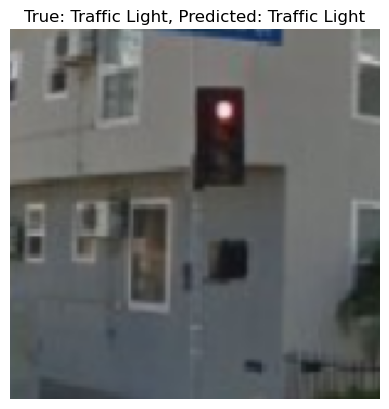

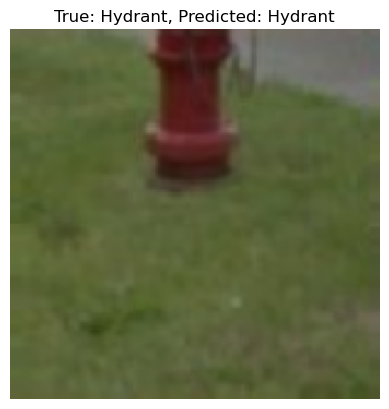

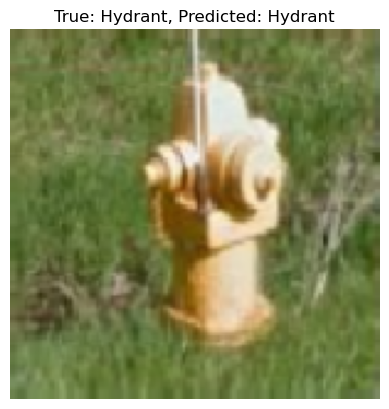

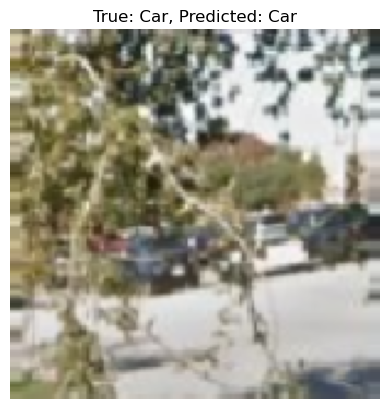

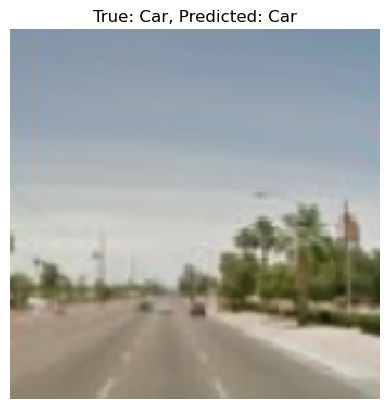

In [64]:
import matplotlib.pyplot as plt

# 클래스 이름 정의 (valid_generator.class_indices는 클래스 이름과 인덱스를 반환)
class_names = list(valid_generator.class_indices.keys())

# 검증 데이터에서 일부 이미지 가져오기
for images, labels in valid_generator:
    preds = best_model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    
    for i in range(5):  # 5개 이미지 확인
        plt.imshow(images[i])
        true_label = class_names[np.argmax(labels[i])]  # 실제 클래스 이름
        predicted_label = class_names[pred_labels[i]]  # 예측된 클래스 이름
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')  # 축 숨기기
        plt.show()
    break


### 여기서부턴 미완성 단계

In [53]:
pip install opencv-python

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 3.2 MB/s eta 0:00:13
   ---------------------------------------- 0.5/38.8 MB 7.3 MB/s eta 0:00:06
   - -------------------------------------- 1.0/38.8 MB 9.4 MB/s eta 0:00:05
   - -------------------------------------- 1.8/38.8 MB 11.2 MB/s eta 0:00:04
   -- ------------------------------------- 2.7/38.8 MB 13.4 MB/s eta 0:00:03
   ---- ----------------------------------- 4.0/38.8 MB 15.8 MB/s eta 0:00:03
   ----- ---------------------------------- 5.6/38.8 MB 18.9 MB/s eta 0:00:02
   ------- -------------------------------- 7.7/38.8 MB 22.2 MB/s eta 0:00:02
   ---------- ----------------------------- 10.3/38.8 MB 28.5 MB/s eta 0:00:02
   -------------- ------------------------- 13.8/38.8 MB 50.4 MB/s eta 0:00:01
   ------------------ --------------------- 17.5/38.8 MB 72.6 MB/s eta 0:00:01
   --------------------- ------------------ 21.3/38.8 MB 81.8 MB/s eta 0

In [48]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection  # Object Detection 모델 및 전처리 도구
from PIL import Image  # 이미지 처리
import requests  # 이미지 URL 요청
import matplotlib.pyplot as plt  # 시각화 도구
import matplotlib.patches as patches  # 박스 그리기 도구

In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Grad-CAM 함수 정의
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 마지막 합성곱 층의 출력에 대한 기울기 계산
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 기울기의 평균값 계산
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 합성곱 층 출력에 기울기 적용
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 활성화 맵을 0과 1 사이로 정규화
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 이미지를 통해 Grad-CAM 결과 시각화
def display_gradcam(img, heatmap, alpha=0.4):
    # 히트맵을 0-255로 변환
    heatmap = np.uint8(255 * heatmap)
    
    # 히트맵을 원본 이미지 크기로 변경
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # 히트맵을 컬러 맵 적용
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # 원본 이미지와 히트맵 합성
    superimposed_img = heatmap * alpha + img
    return np.uint8(superimposed_img)

# 모델의 마지막 합성곱 층 이름을 확인하세요 (InceptionV3의 경우 'conv2d_94'일 수 있습니다).
last_conv_layer_name = 'conv2d_94'  # 합성곱 층 이름을 확인해서 변경하세요.

# 검증 데이터에서 이미지 하나 가져오기
for images, labels in valid_generator:
    img = images[0]  # 첫 번째 이미지 사용
    img_array = np.expand_dims(img, axis=0)  # 모델에 넣기 위한 차원 확장

    # Grad-CAM 히트맵 생성
    heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name = "mixed10")

    # 원본 이미지와 히트맵 합성
    superimposed_img = display_gradcam(img, heatmap)

    # 이미지 출력
    plt.imshow(superimposed_img)
    plt.title(f"Predicted: {class_names[np.argmax(preds)]}, True: {class_names[np.argmax(labels[0])]}")
    plt.axis('off')
    plt.show()
    break


ValueError: No such layer: mixed10. Existing layers are: ['inception_v3', 'global_average_pooling2d_3', 'dropout_3', 'dense_3'].

In [75]:
from PIL import Image, ImageDraw

# 이미지 파일 경로
image_path = "C:/Users/DELL/Downloads/archive/Google_Recaptcha_V2_Images_Dataset/images/Chimney/Chimney (9).png"
# 텍스트 파일 경로
text_file_path = "C:/Users/DELL/Downloads/archive/Google_Recaptcha_V2_Images_Dataset/labels/Chimney/Chimney (9).txt"

# 이미지 열기
with Image.open(image_path) as img:
    # 이미지 크기 얻기
    image_width, image_height = img.size

# 드로우 객체 생성
draw = ImageDraw.Draw(img)

# 텍스트 파일에서 박스 좌표 읽기
with open(text_file_path, 'r') as file:
    for line in file:
        # 좌표를 공백으로 나누어 리스트로 변환
        coords = list(map(float, line.split()))
        # coords = [class_id, x_center, y_center, width, height]

# 정규화된 좌표를 이미지 좌표로 변환
x_center = coords[1] * image_width
y_center = coords[2] * image_height
width = coords[3] * image_width
height = coords[4] * image_height

# 좌표 계산
x1 = int(x_center - width / 2)
y1 = int(y_center - height / 2)
x2 = int(x_center + width / 2)
y2 = int(y_center + height / 2)

# 박스 그리기 (테두리 색상: 빨간색, 두께: 3)
draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

# 이미지 보여주기
img.show()

# 변경된 이미지를 저장하고 싶다면
# img.save('output_image.png')

AttributeError: 'NoneType' object has no attribute 'seek'